# Tutorial
`g3p` is a header-only *Modern C++* interface 
libray for [`gnuplot`](http://www.gnuplot.info). As it supports displaying plots in *Jupyter C++ Notebooks* backed by [`xeus-cling`](https://github.com/jupyter-xeus/xeus-cling), it makes a lot of sense to start learning  `g3p` by examples in a *Jupyter* notebook interactively.

[`gnuplot`](http://www.gnuplot.info) comes with lots of demos that you can find them [HERE](http://gnuplot.info/demos). We first start with [`simple functions`](https://gnuplot.sourceforge.net/demo_5.4/simple.html).

## 1. The header file
There's a single header file in `g3p` that you have to include once:

In [1]:
#include <g3p/gnuplot>

## 2. `gnuplot` instance
Now you can start with a `gnuplot` instance that is defined in `g3p` namespace. We name our instance `gp`:

In [2]:
g3p::gnuplot gp;

## 3. The basics
There are two ways to send string literals (e.g. `gnuplot` commands)  and variables to the `gnuplot` instance: `C` and `C++` conventions. You can even mix and match them. Let's start with the latter.
### 3.1. `C++` *convention*
For our first plot we use the `C++` *convention* and use almost a verbatim copy of the [`Simple Plots`](https://gnuplot.sourceforge.net/demo_5.4/simple.html) demo:

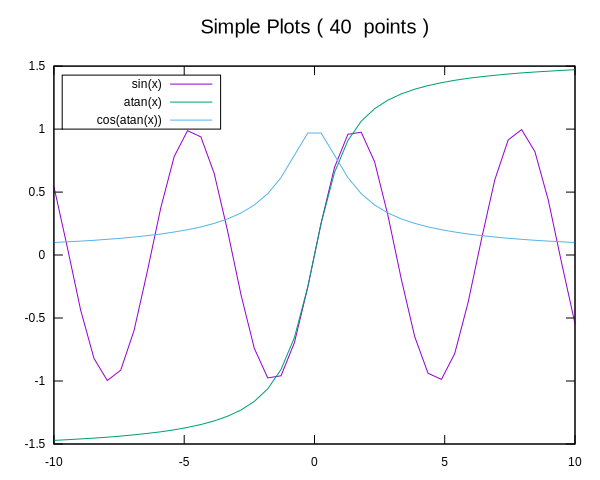

In [3]:
int count = 40;
gp << "set title 'Simple Plots (" << count << " points )' font ',20'\n"
   << "set key left box\n"
   << "set samples" << count << "\n"
   << "set style data points\n"
   << "plot [-10:10] sin(x),atan(x),cos(atan(x))\n"

As you may have noticed in the previous plot, to display the plot, you need to have a `gnuplot` instance without a semicolon as the last element of a code cell. So, to replot the previous one, you can type the name of the `gnuplot` instance without semicolon and then <kbd>shift</kbd>+<kbd>enter</kbd>:

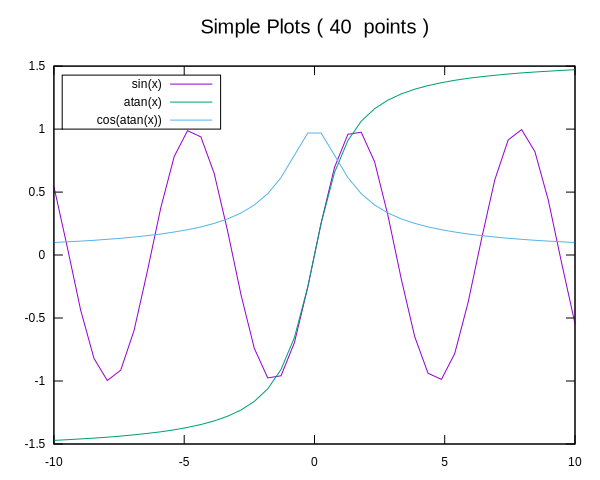

In [4]:
gp

Another way to achieve this is using the `xcpp::display()` function. A subtle distinction between using `xcpp::display()` and omitting the last semicolon is that the latter results in a cell output including a prompt number, while the former only shows the plot. This behaviour is consistent with the Python kernel implementation.

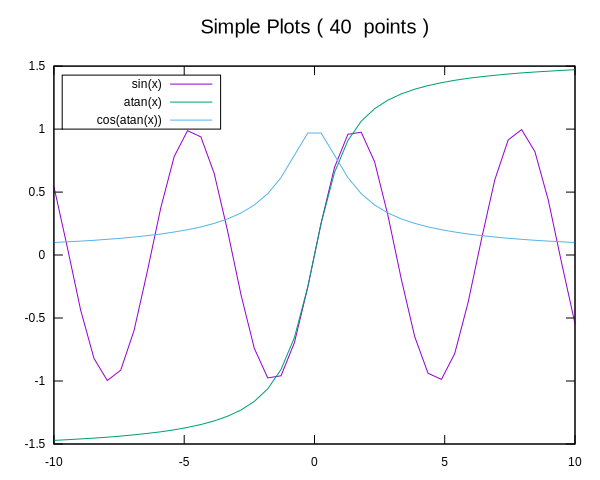

In [5]:
xcpp::display(gp);

### 3.2. `C` *convention*
Now we will plot it again with more points using `C` *convention*:

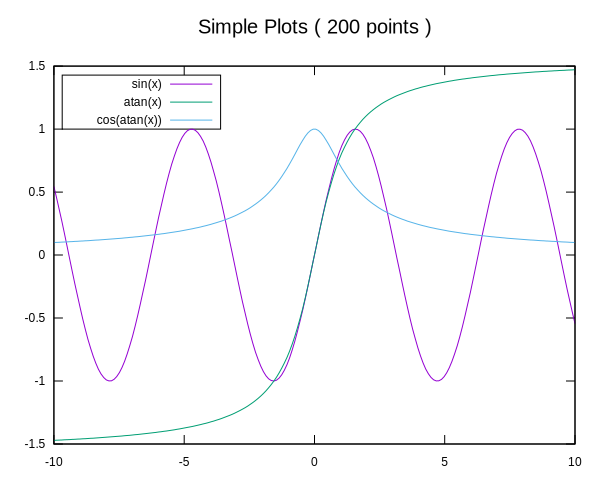

In [6]:
count = 200;
gp ( "set title 'Simple Plots ( %d points )'", count )
   ( "set samples %d", count)
   ( "replot" )

### 3.3. Newline
As you may noticed in the above examples, one important difference between `C++` and `C` *conventions* is that a newline character will be added automatically at the end of the string literals for the latter. In `g3p`, there are various ways to send a newline to a `gnuplot` instance:
- **Implicit**
  - String literal in parenthesis (i.e. overloaded function operator): `gp("...")`
- **Explicit**
  - String literal: `gp << "\n"` (NOTE: unlike C++ streams, single quotes are not valid. So, `gp << '\n'` doesn't compile)
  - End-of-line member function: `gp.endl()`
  - End-of-line manipulator: `gp << g3p::endl`

Like [`std::endl`](https://en.cppreference.com/w/cpp/io/manip/endl) manipulator for C++ streams, `g3p::endl` inserts a newline character and also flushes it by calling `gnuplot::flush()`, which doesn't happen for other methods. See section [3.4](#3.4.-Flush) for more information.

Let's try all of the above methods in the same order for our next plot:

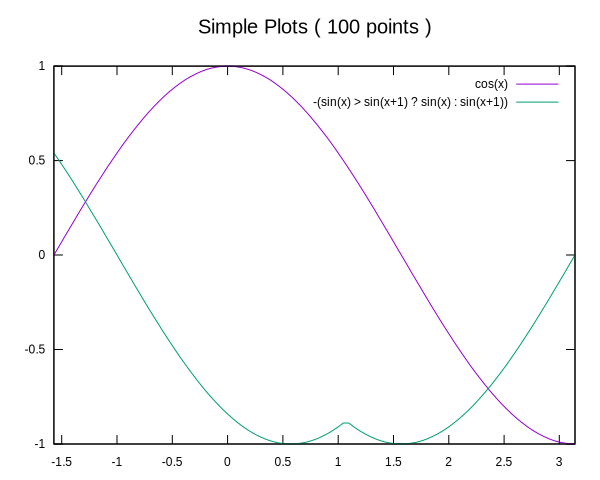

In [7]:
count = 100;
gp (  "set title 'Simple Plots ( %d points )", count ); // implicit
gp << "set key right nobox" << "\n";                    // explicit - string literal
gp <<  "set samples" << count;
gp.endl();                                              // explicit - member function
gp << "plot [-pi/2:pi] cos(x),-(sin(x) > sin(x+1) ? sin(x) : sin(x+1))"
   << g3p::endl                                         // explicit - manipulator

### 3.4. Flush
`g3p` uses buffered i/o to communicate with `gnuplot` instances. That means the plotting commands you use in your `C/C++` code are not necessarily received by `gnuplot` instance at any moment unless you ensure the buffer is flushed. That's particularly important after executing [`plot`](http://gnuplot.info/docs_5.5/loc7782.html), [`splot`](http://gnuplot.info/docs_5.5/loc17814.html) or [`replot`](http://gnuplot.info/docs_5.5/loc9853.html) commands to ensure the plot is displayed. Like newline, there are various ways in `g3p` to flush the buffers:
- **Implicit** (available only in Jupyter Notebooks)
  - Omitting semicolon from a `gnuplot` instance as the last element of a cell or using `xcpp::display(gp)`
- **Explicit**
  - End-of-line member function: `gp.endl()`
  - Flush member function: `gp.flush()`
  - Log member function: `gp.log()`
  - Flush manipulator: `gp << g3p::flush`


## 4. Embedding data into a stream of `gnuplot` commands
So far, we've used functions defined in `gnuplot` for plotting. While it's perfectly fine to use `g3p` to produce plots using pure `gnuplot` facilities, as is usually the case, the whole point of using `g3p` is to plot data generated by `C/C++` functions. There are two mechanisms for embedding data into a stream of `gnuplot` commands and we're going to explore them in the next two sections.

### 4.1. Inline data
If the *special filename* `'-'` appears in a plot command, then the lines immediately following the plot command are interpreted as *inline data*. To demonstrate that, let's first define a function template. We use [Matlab's Peaks](https://www.mathworks.com/help/matlab/ref/peaks.html) as our function:

In [8]:
#include <cmath>

template<typename T = float>
auto matlab_peaks(T x1, T x2) -> T
{   return
        (   T(3)
        *   std::pow(T(1) - x1, T(2))
        *   std::exp(-std::pow(x1, T(2)) - std::pow(x2 + T(1), T(2)))
        -   (T(10) * (x1 / T(5) - std::pow(x1, T(3)) - std::pow(x2, T(5))) * std::exp(-std::pow(x1, T(2)) - std::pow(x2, T(2))))
        -   (T(1) / T(3) * std::exp(-std::pow(x1 + T(1), T(2)) - std::pow(x2, T(2))))
        );
}

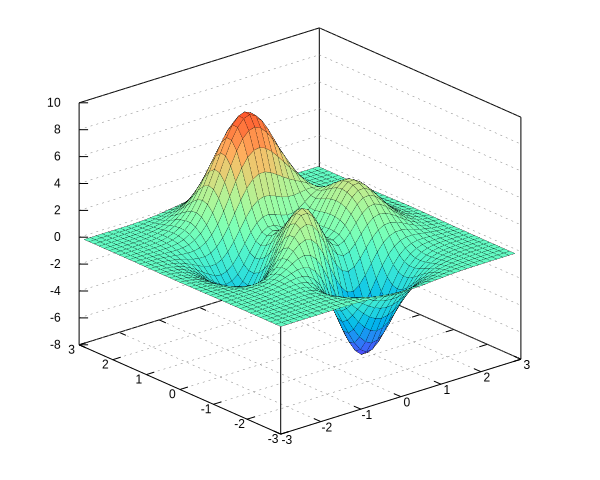

In [9]:
// let's start with a new gp instance
g3p::gnuplot gp;

// setting our plot
gp  ("set nokey")
    ("set view 60, 320,,1.2")
    ("set border 895")
    ("unset colorbox")
    ("set grid x y z")
    ("set xrange[-3:3]")
    ("set yrange[-3:3]")
    ("set zrange[-8:10]")
    ("set ticslevel 0")
    ("set palette rgb 33,13,10")
    ("set pm3d")
    ("set pm3d depthorder border")
    ("splot '-' with lines lc 'black' lw 0.2");
//           ^ --> tells gnuplot that data is coming after this command

// now we can start embedding our inline data...
for (float i = -3.0f; i < 3.0f; i += 0.15f)
{   for (float j = -3.0f; j < 3.0f; j += 0.15f) 
        gp << i << j << matlab_peaks(i, j) << "\n";
    gp.endl();
}

// once the data stream is finished we have to inform
// gnuplot by sending the end signal:
gp.end()

### 4.2. Datablocks
Data provided in the previous method can only be used once, by the plot command it follows. Often, we want to use the data referenced by more than one plot command in the same plot or multiplots. That's where *datablocks* come into play. You just need to define the datablock once and then you can use its name to refer to it. Here is the multiplot of the same Peaks function using *datablocks*:

In [10]:
#include <vector>

// we first put our data in a 3d vector
std::vector<float> grid(40 * 40 * 3); // 40 x 40 x 3 grid
auto itr = std::begin(grid);
for (float i = -3.0f; i <= 3.0f; i += 0.15f)
    for (float j = -3.0f; j <= 3.0f; j += 0.15f)
    {   *itr++ = i;
        *itr++ = j;
        *itr++ = matlab_peaks(i, j);
    }

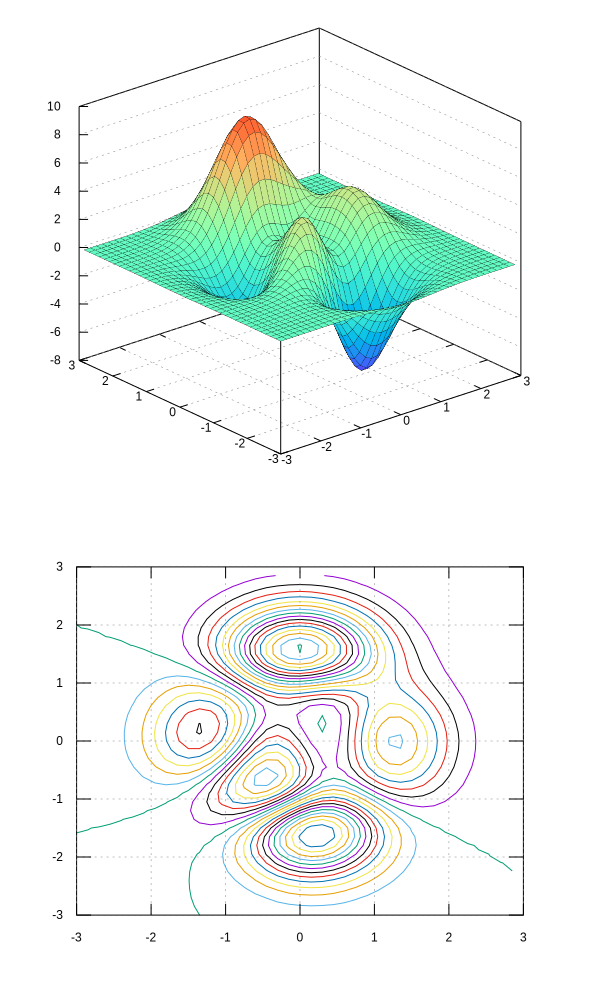

In [11]:
// we use make_data_block function provided by g3p
// to turn our vector into a datablock
auto peaks = make_data_block(gp, grid, 3, 40);

// now we can use it in a multiplot
// NOTE: we mix and match C and C++ conventions here...
gp  ("set term svg size 600 1000")
    ("set multiplot layout 2,1 spacing 0,0")
    << "splot"
    << peaks // <-- using peaks once
    << "with lines lc 'black' lw 0.2\n";
gp  ("set view map")
    ("set contour")
    ("set cntrparam levels 50")
    ("unset surface")
    << "splot"
    << peaks // <-- using peaks twice
    << "w lines\n"
    << "unset multiplot\n"

## 5. Animation
`gnuplot` supports a large number of [output formats (i.e. terminals)](http://gnuplot.info/docs_5.5/Terminals.html). A few of them can be embedded in a Jupyter Notebook: [gif](http://gnuplot.info/docs_5.5/loc20476.html), [jpeg](http://gnuplot.info/docs_5.5/loc20716.html), [png](http://gnuplot.info/docs_5.5/loc21324.html), [pngcairo](http://gnuplot.info/docs_5.5/loc21400.html), and last but not least [svg](http://gnuplot.info/docs_5.5/loc22178.html). The default terminal used by `g3p` for a new `gnuplot` instance in a Jupyter Notebook is `svg`. Based on your plotting needs, you can switch to any other formats mentioned in the above list.

One particularly important one is the `gif` terminal because it's the only format that supports animation out of the box. Below is an example of an animation generated using `gif` terminal. This one is based on the excellent example at [**https://gnuplotting.org**](https://gnuplotting.org/animation-gif/).

✋**NOTE:** Depending on the frame size and the number of frames it may take a while for the animation to appear.

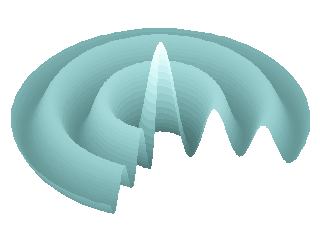

In [12]:
g3p::gnuplot gp;
gp  ("set term gif size 320,240 animate") // setting output format and size
    ("set palette rgb 3,9,9")
    ("unset key; unset colorbox; unset border; unset tics")
    ("set lmargin at screen 0.03")
    ("set bmargin at screen 0")
    ("set rmargin at screen 0.97")
    ("set tmargin at screen 1")
    ("set parametric")
    ("bessel(x,t) = besj0(x) * cos(2*pi*t)")
    ("n = 6 # number of zeros")
    ("k = (n*pi-1.0/4*pi)")
    ("u_0 = k + 1/(8*k) - 31/(384*k)**3 + 3779/(15360*k)**5")
    ("set urange [0:u_0]")
    ("set vrange[0:1.5*pi]")
    ("set cbrange [-1:1]")
    ("set zrange[-1:1]")
    ("set isosamples 200,100")
    ("set pm3d depthorder")
    ("set view 40,200")
;
for (float t = 0.0f; t < 2.0f; t += 0.02f)
    gp("splot u*sin(v),u*cos(v),bessel(u,%f) w pm3d ls 1", t);
gp

## 6. Troubleshooting
While tinkering with a plot, there are times that you get an unexpected output or not anything at all. `g3p` provides three ways to communicate with `gnuplot` instance to get more information and those are the subjects of the next sections.
### 6.1. `last_error()` member function

### 6.2. `log()` member function

### 6.3. `>>` operator

